In [1]:
from __future__ import print_function, division
import numpy as np
import scipy as sp

import mat_neuron._model as mat
from dstrf import strf, mle

# plotting packages
%matplotlib inline
import matplotlib.pyplot as plt # plotting functions
import seaborn as sns           # data visualization package
sns.set_style("whitegrid")

/home/dmeliza/.virtualenvs/dstrf/local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
# model parameters: (α1, α2, ω, τ1, τ2, tref)
matparams = np.asarray([100, 2, 7, 10, 200, 2], dtype='d')
model_dt = 0.5

# data parameters
duration = 50000
n_samples = int(duration / model_dt)
n_assim = 3
n_test = 0

/home/dmeliza/.virtualenvs/dstrf/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


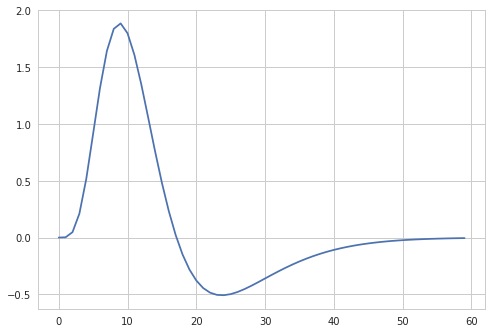

In [3]:
# convolution - simple alpha kernel
from scipy.signal import resample
stim_dt = 10.0
upsample = int(stim_dt / model_dt)

# alpha filter
tau_h = 50
tt = np.arange(0, 600, stim_dt)
ka = np.flipud(tt / tau_h * np.exp(-tt / tau_h))

# difference of gammas:
from scipy.special import gamma
tau_h1 = 600. / 32
tau_h2 = 600. / 16
kg1 = 1/(gamma(6)*tau_h1)*(tt/tau_h1)**5 * np.exp(-tt/tau_h1)
kg2 = 1/(gamma(6)*tau_h2)*(tt/tau_h2)**5 * np.exp(-tt/tau_h2)
kg = np.flipud(kg1 - kg2 / 1.5)
kg /= np.linalg.norm(kg)

# select a filter
k1 = (kg * 5)[::-1]
plt.plot(k1)
    

In [4]:
def filter_stimulus(S, k1):
    return np.convolve(S, k1, mode="full")[:S.size]

def predict_spikes(V, params, dt, upsample):
    a1, a2, omega, t1, t2, tref = params
    return mat.predict_poisson(V - omega, (a1, a2), (t1, t2), tref, 
                               dt, upsample)

In [5]:
# generate data to fit
np.random.seed(1)
mat.random_seed(1)
data = []
stim = np.random.randn(int(n_samples / (stim_dt / model_dt)))
stim[:100] = 0
        
V = filter_stimulus(stim, k1)
for i in range(n_assim + n_test):
    spikes = predict_spikes(V, matparams, model_dt, upsample)
    H = mat.adaptation(spikes, matparams[3:5], model_dt)
    z = np.nonzero(spikes)[0]
    d = {"H": H,
         "duration": duration,
         "spike_t": z, 
         "spike_v": spikes,
        }
    data.append(d)

# split into assimilation and test sets
assim_data = data[:n_assim]
test_data = data[n_assim:]

spikes: 239.333333333; rate: 0.00478666666667 / dt


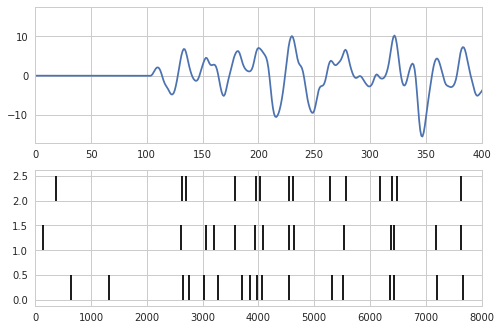

In [6]:
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
for i, d in enumerate(data):
    ax2.vlines(d["spike_t"], i, i + 0.5)
ax1.plot(V)
ax1.set_xlim(0, 8000 // upsample)
ax2.set_xlim(0, 8000)
print("spikes: {}; rate: {} / dt".format(np.mean([d["spike_t"].size for d in data]), 
                                         np.mean([d["spike_t"].size / d["duration"] for d in data])))

### Estimation

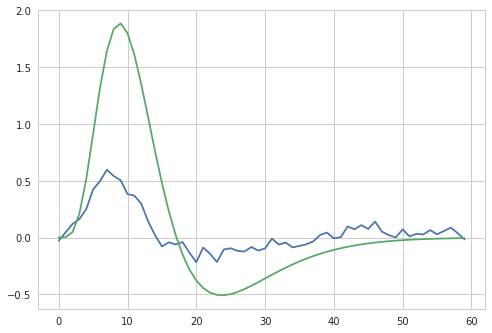

In [7]:
from theano import config
import scipy.optimize as op

ftype = config.floatX
# combine the trials
spikes = np.stack([d["spike_v"] for d in data], axis=1).astype(ftype)
# spikes in the exponential basis set
X_spikes = np.stack([d["H"] for d in data], axis=2).astype(ftype)
# generate design matrix for stimulus
X_stim = strf.lagged_matrix(stim.reshape(1, stim.size), k1.size).astype(ftype)
# initial guess of strf
sta = strf.correlate(X_stim, spikes)
plt.plot(sta[::-1])
plt.plot(k1)

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <type 'exceptions.TypeError'> ('The type of the replacement must be compatible with the type of the original Variable.', Reshape{2}.0, Reshape{2}.0, TensorType(float64, col), TensorType(float64, matrix), 'local_useless_dimshuffle_in_reshape') local_useless_dimshuffle_in_reshape
ERROR (theano.gof.opt): Optimization failure due to: local_useless_dimshuffle_in_reshape
ERROR (theano.gof.opt): node: Reshape{2}(InplaceDimShuffle{0}.0, <TensorType(int64, vector)>)
ERROR (theano.gof.opt): TRACEBACK:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/home/dmeliza/.virtualenvs/dstrf/local/lib/python2.7/site-packages/theano/gof/opt.py", line 2022, in process_node
    remove=remove)
  File "/home/dmeliza/.virtualenvs/dstrf/local/lib/python2.7/site-packages/theano/gof/toolbox.py", line 391, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/home/dmeliza/.virtualenvs/dstrf/local/lib/python

array(2744.9621405859607)

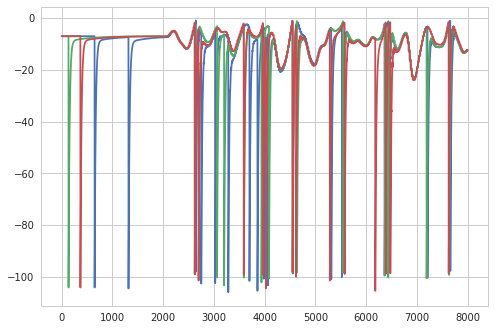

In [ ]:
lfuns = mle.make_likelihood(X_stim, X_spikes, spikes, stim_dt, model_dt)
w = np.r_[matparams[2], matparams[:2], k1[::-1]].astype(ftype)
lci = lfuns['lci'](w)
plt.plot(lci[:8000])
lfuns['loglike'](w)

In [ ]:
%%time
w0 = np.r_[0, 0, 0, sta]
w1 = op.fmin_ncg(lfuns['loglike'], w, lfuns['gradient'], 
                 fhess_p=lfuns['hessianv'], maxiter=100)

In [ ]:
print(w1[:3])
rf_est = w1[:3:-1]
plt.plot(rf_est)
plt.plot(w0[:3:-1])
plt.plot(k1)